# Statistical Analysis: 
- Did the new page actually win?
- Did the Treatment group buy more than the Control group?

In [1]:
import pandas as pd

In [8]:
# Load Data
df_cleaned = pd.read_csv('C:\\Users\\tinot\\Desktop\\Projects\\ABTesting_ECommerce_LandingPage\\data\\ab_test_cleaned.csv')

# Quick look at the top rows
print(df_cleaned.head())

# Check the structure
print(f"Dataset Shape: {df_cleaned.shape}")


   user_id timestamp      group landing_page  converted
0   851104   11:48.6    control     old_page          0
1   804228   01:45.2    control     old_page          0
2   661590   55:06.2  treatment     new_page          0
3   853541   28:03.1  treatment     new_page          0
4   864975   52:26.2    control     old_page          1
Dataset Shape: (290584, 5)


# Calculate the "Raw" Conversion Rates

This is simple division: People who bought \ Total people

- Observation: The Treatment group (New Page) is actually lower than the Control group.

- Immediate Insight: We hoped the new page would increase sales. It didn't. In fact, it looks slightly worse.

- Why do we still need stats? Even though it looks worse, is it actually worse? Or is 11.88% basically the same as 12.04% and the difference is just random luck? That is why we run the test.

In [10]:
# 1. Calculate the actual conversion rates
conversion_rates = df_cleaned.groupby('group')['converted'].agg(['sum', 'count', 'mean'])
conversion_rates.columns = ['converted_users', 'total_users', 'conversion_rate']

# Style it to look like a percentage
print(conversion_rates.style.format({'conversion_rate': '{:.2%}'}))

# 2. Compare to our Baseline
control_rate = conversion_rates.loc['control', 'conversion_rate']
treatment_rate = conversion_rates.loc['treatment', 'conversion_rate']

print(f"Control Rate: {control_rate:.4f}")
print(f"Treatment Rate: {treatment_rate:.4f}")

Control Rate: 0.1204
Treatment Rate: 0.1188


# Z-Test

The Decision Framework:
1. What kind of data is it?
- It is Binary (Yes/No, Converted/Not Converted).
- This is called a Proportion.
2. How much data do we have?
- We have 290,000 rows. This is Large.

The Selection:
- T-Test: Usually used for Averages (e.g., "Did the average amount spent increase?"). It is also used for small sample sizes (< 30).
- Chi-Square: Used if you have multiple variations (e.g., Version A vs. Version B vs. Version C).
- Z-Test: The Gold Standard for comparing two Proportions with Large Sample Sizes.

We selected a Two-Proportion Z-Test because the dependent variable was binary (conversion) and the sample size was sufficiently large (n > 30) to satisfy the Central Limit Theorem."


In [11]:
# 3. Perform the Z-test
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# Prepare the data for the test
control_results = df_cleaned[df_cleaned['group'] == 'control']['converted']
treatment_results = df_cleaned[df_cleaned['group'] == 'treatment']['converted']

n_control = control_results.count()
n_treatment = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_control, n_treatment]

# Run Z-test
z_stat, pval = proportions_ztest(successes, nobs=nobs)

print(f"Z Statistic: {z_stat:.4f}")
print(f"P-Value: {pval:.4f}")

Z Statistic: 1.3109
P-Value: 0.1899


**Results**:
Z Statistic: 1.3109
P-Value: 0.1899The 

- The Translation: "There is a 19% chance that the difference between the old page and new page is just a total coincidence."
- The Conclusion: That is too risky. We Fail to Reject the Null Hypothesis. We cannot say the pages are different.

# Confidence Intervals

In [12]:
# 4. Calculate Confidence Intervals (95%)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f"Control 95% CI: [{lower_con:.4f}, {upper_con:.4f}]")
print(f"Treatment 95% CI: [{lower_treat:.4f}, {upper_treat:.4f}]")

Control 95% CI: [0.1187, 0.1221]
Treatment 95% CI: [0.1171, 0.1205]


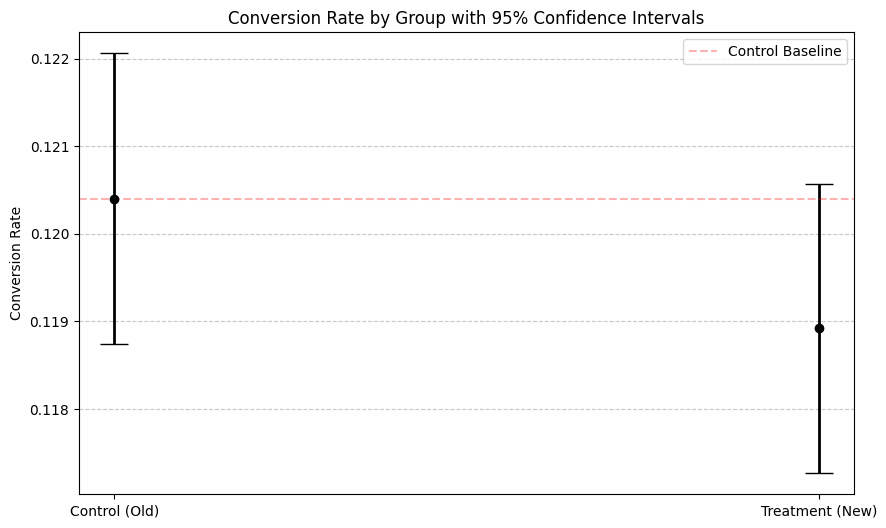

In [7]:
# 5. Visualization: Confidence Intervals
import numpy as np
import matplotlib.pyplot as plt

# Calculate standard error for both groups
se_control = np.sqrt(control_rate * (1 - control_rate) / n_control)
se_treatment = np.sqrt(treatment_rate * (1 - treatment_rate) / n_treatment)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Define the x-locations for the groups
x = [0, 1]
rates = [control_rate, treatment_rate]
errors = [1.96 * se_control, 1.96 * se_treatment]  # 1.96 is for 95% CI

# Create the error bar plot
ax.errorbar(x, rates, yerr=errors, fmt='o', linewidth=2, capsize=10, color='black')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Control (Old)', 'Treatment (New)'])
ax.set_ylabel('Conversion Rate')
ax.set_title('Conversion Rate by Group with 95% Confidence Intervals')

# Add a reference line for the Control rate to see if Treatment crosses it
ax.axhline(y=control_rate, color='r', linestyle='--', alpha=0.3, label='Control Baseline')

plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()